In [1]:
import os
import glob
import json

import pandas as pd
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_FOLDER = '../data/za_traffic_2020'

In [3]:
# 1. Inspect images

In [4]:
train_image_paths = glob.glob(os.path.join(DATA_FOLDER, 'traffic_train', 'images', '*.png'))
print('Number of training images: ', len(train_image_paths))

test_image_paths = glob.glob(os.path.join(DATA_FOLDER, 'traffic_public_test', 'images', '*.png'))
print('Number of testing images: ', len(test_image_paths))

Number of training images:  4500
Number of testing images:  586


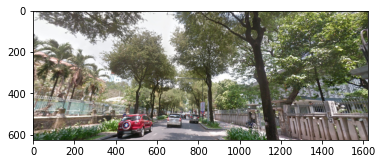

In [5]:
ex1 = plt.imread(train_image_paths[0])
plt.imshow(ex1)
plt.show()

In [6]:
# 2. Inspect label file

In [7]:
with open(os.path.join(DATA_FOLDER, 'traffic_train', 'train_traffic_sign_dataset.json')) as f:
    raw_info = json.load(f)

In [8]:
categories = raw_info['categories']
info_images = raw_info['images']
annotations = raw_info['annotations']

In [9]:
def get_list_var(_list, var_name):
    return [i[var_name] for i in _list]

def create_dataframe(_list):
    schema = _list[0].keys()
    _dict = dict()
    for s in schema:
        _dict[s] = get_list_var(_list, s)
    return pd.DataFrame(_dict)

def split_bbox(df):
    df['x'] = df['bbox'].map(lambda x: x[0])
    df['y'] = df['bbox'].map(lambda x: x[1])
    df['w'] = df['bbox'].map(lambda x: x[2])
    df['h'] = df['bbox'].map(lambda x: x[3])
    return df

In [10]:
images_pd = create_dataframe(info_images)
annotations_pd = create_dataframe(annotations)
categories_pd = create_dataframe(categories)

# join images info with annotations
image_anno_pd = pd.merge(left=images_pd, right=annotations_pd, how='left',
                        left_on='id', right_on='image_id', suffixes=['', '_bbox'])

In [11]:
image_anno_pd = split_bbox(image_anno_pd)

In [12]:
## 2.1. Label classes

In [13]:
print('Number of label classes:', len(categories))

Number of label classes: 7


In [14]:
categories

[{'supercategory': 'Cấm ngược chiều', 'id': 1, 'name': 'Cấm ngược chiều'},
 {'supercategory': 'Cấm dừng và đỗ', 'id': 2, 'name': 'Cấm dừng và đỗ'},
 {'supercategory': 'Cấm rẽ', 'id': 3, 'name': 'Cấm rẽ'},
 {'supercategory': 'Giới hạn tốc độ', 'id': 4, 'name': 'Giới hạn tốc độ'},
 {'supercategory': 'Cấm còn lại', 'id': 5, 'name': 'Cấm còn lại'},
 {'supercategory': 'Nguy hiểm', 'id': 6, 'name': 'Nguy hiểm'},
 {'supercategory': 'Hiệu lệnh', 'id': 7, 'name': 'Hiệu lệnh'}]

## 2.2. Image size:
- All images have the same size (W=1622, H=626)

In [15]:
image_anno_pd['width'].value_counts()

1622    11000
Name: width, dtype: int64

In [16]:
image_anno_pd['height'].value_counts()

626    11000
Name: height, dtype: int64

## 2.3. Streets:
- 38 unique streets

In [17]:
image_anno_pd['street_id'].nunique()

38

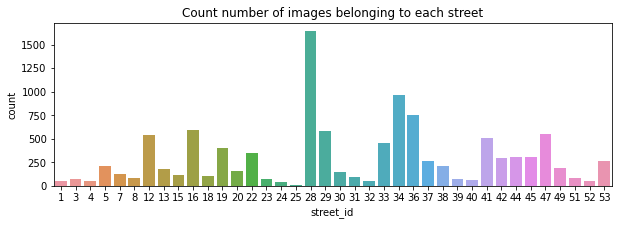

In [18]:
plt.figure(figsize=(10,3))
sns.countplot(x='street_id', data=image_anno_pd)
plt.title('Count number of images belonging to each street')
plt.show()

## 2.4. Annotations:
- No segmentation info
- Most of the images have 1 bbox annotation
- Most of the annotation bboxes top left point lies around the center of the images
- Strong positive linear correlation between bbox width and height

In [19]:
print('Number of annotation bboxes: ', len(image_anno_pd))

Number of annotation bboxes:  11000


/home/nam/anaconda3/envs/vnpost_ocr/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


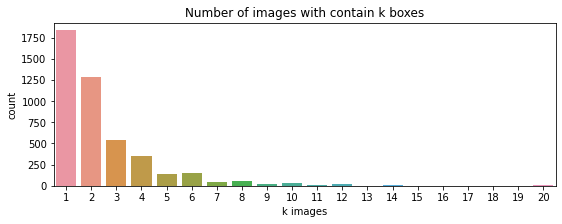

In [20]:
plt.figure(figsize=(9,3))
count_box_per_img = image_anno_pd.groupby('image_id').count()['id']
sns.countplot(count_box_per_img)
plt.title('Number of images with contain k boxes')
plt.xlabel('k images')
plt.show()

In [21]:
n_image_no_bboxes = image_anno_pd.id_bbox.isnull().sum()
print('Number of image having no annotation box: {}'.format(n_image_no_bboxes))

Number of image having no annotation box: 0


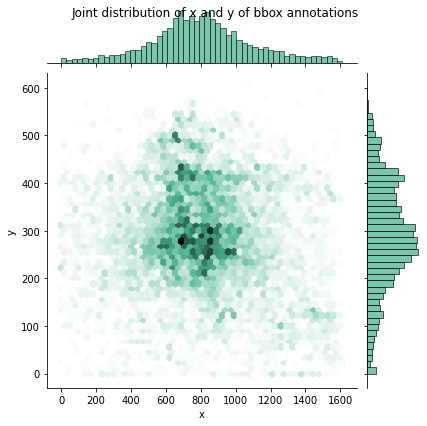

In [22]:
ax = sns.jointplot(data=image_anno_pd, x='x', y='y', kind="hex", color="#4CB391")
ax.fig.suptitle("Joint distribution of x and y of bbox annotations")
plt.show()

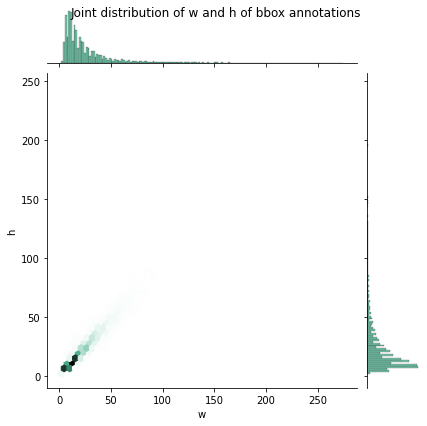

In [23]:
ax = sns.jointplot(data=image_anno_pd, x='w', y='h', kind="hex", color="#4CB391")
ax.fig.suptitle("Joint distribution of w and h of bbox annotations")
plt.show()

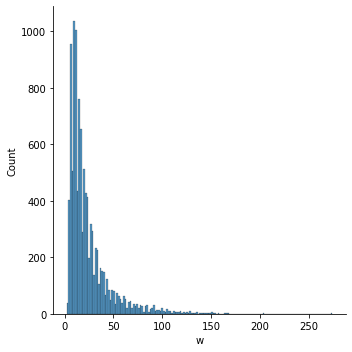

In [26]:
sns.displot(image_anno_pd['w'])

### Distribution of traffic sign categories
- A bit unbalance between classes

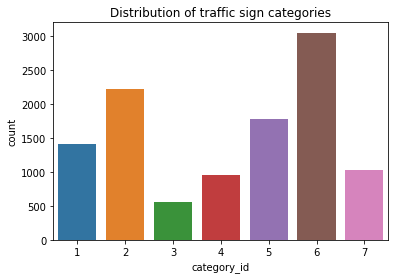

In [29]:
sns.countplot(image_anno_pd.category_id)
plt.title('Distribution of traffic sign categories')
plt.show()

## Draw annotations on 1 image

In [35]:
def draw_bbox(img, x, y, w, h, color=(255,0,0)):
    draw = img.copy()
    print(x, y, w, h)
    cv2.rectangle(draw, (x, y), (x+w, y+h), color, 3)
    return draw

def plot_cv2_img(img, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.show()
    
def show_1_image_with_bboxes(df, ex_img_id):
    example_pd = df[df['image_id'] == ex_img_id]
    img = cv2.imread(os.path.join(DATA_FOLDER, 'traffic_train', 'images', example_pd['file_name'].iloc[0]))
    draw = img.copy()
    for i, row in example_pd.iterrows():
        draw = draw_bbox(draw, row['x'], row['y'], row['w'], row['h'])
    plot_cv2_img(draw)

1069 355 83 83
768 480 9 7


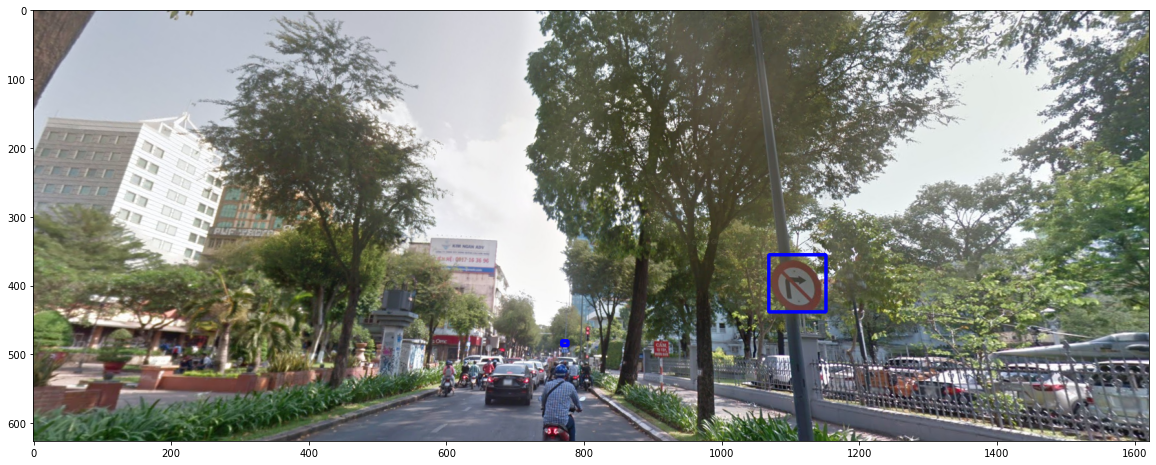

In [36]:
ex_img_id = 5
show_1_image_with_bboxes(image_anno_pd, ex_img_id)

In [37]:
# Convert label to csv

In [38]:
# ratio = 640/1622
ratio = 1

In [42]:
def apply_ratio(df, cols, ratio=ratio):
    for c in cols:
        df[c] = (df[c]*ratio).astype(int)

image_anno_pd['frame'] = image_anno_pd['file_name']
image_anno_pd['xmin'] = image_anno_pd['x']
image_anno_pd['ymin'] = image_anno_pd['y']
image_anno_pd['xmax'] = image_anno_pd['x'] + image_anno_pd['w']
image_anno_pd['ymax'] = image_anno_pd['y'] + image_anno_pd['h']
image_anno_pd['class_id'] = image_anno_pd['category_id']

apply_ratio(image_anno_pd, ['width', 'height', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])

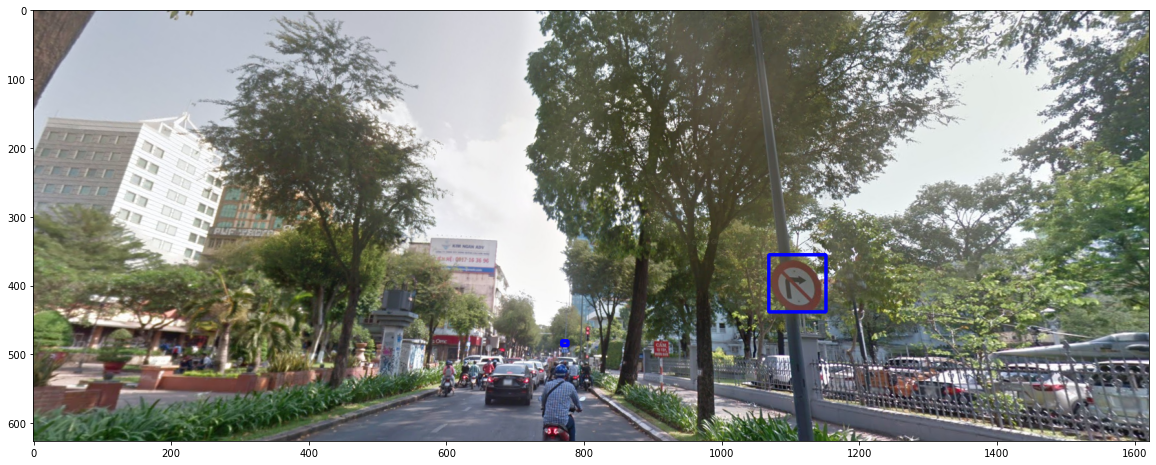

In [43]:
# Test annotation
example_pd = image_anno_pd[image_anno_pd['image_id'] == ex_img_id]
img = cv2.imread(os.path.join(DATA_FOLDER, 'traffic_train', 'images', example_pd['file_name'].iloc[0]))
img = imutils.resize(img, width=int(1622*ratio))

draw = img.copy()

for i, row in example_pd.iterrows():
    cv2.rectangle(draw, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (255, 0, 0), 3)
    
plot_cv2_img(draw)

In [44]:
cols_to_save = ['frame','width', 'height', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id']

In [45]:
image_anno_pd[cols_to_save].to_csv(os.path.join(DATA_FOLDER, 'traffic_train',
                                                'train_traffic_sign_dataset.csv'),
                                  index=False)

In [46]:
image_anno_pd

file_name  height  width     id  street_id segmentation   area  \
0          3.png     626   1622      3          3           []    342   
1          5.png     626   1622      5          4           []   6889   
2          5.png     626   1622      5          4           []     63   
3          6.png     626   1622      6          5           []    255   
4         16.png     626   1622     16          3           []     56   
...          ...     ...    ...    ...        ...          ...    ...   
10995  12519.png     626   1622  12519         45           []  27300   
10996  12521.png     626   1622  12521         49           []   1968   
10997  12523.png     626   1622  12523         53           []    420   
10998  12523.png     626   1622  12523         53           []    336   
10999  12523.png     626   1622  12523         53           []    240   

       iscrowd  image_id                  bbox  ...     x    y    w    h  \
0            0         3    [880, 333, 19, 18]  ...   880  333   19   18   
1            0         5   [1069, 355, 83, 83]  ...  1069  355   83   83   
2            0         5      [768, 480, 9, 7]  ...   768  480    9    7   
3            0         6    [781, 337, 17, 15]  ...   781  337   17   15   
4            0        16      [733, 352, 7, 8]  ...   733  352    7    8   
...        ...       ...                   ...  ...   ...  ...  ...  ...   
10995        0     12519  [902, 290, 273, 100]  ...   902  290  273  100   
10996        0     12521   [1338, 173, 48, 41]  ...  1338  173   48   41   
10997        0     12523    [800, 256, 20, 21]  ...   800  256   20   21   
10998        0     12523    [800, 281, 21, 16]  ...   800  281   21   16   
10999        0     12523    [969, 335, 15, 16]  ...   969  335   15   16   

           frame  xmin ymin  xmax  ymax  class_id  
0          3.png   880  333   899   351         2  
1          5.png  1069  355  1152   438         3  
2          5.png   768  480   777   487         2  
3          6.png   781  337   798   352         6  
4         16.png   733  352   740   360         2  
...          ...   ...  ...   ...   ...       ...  
10995  12519.png   902  290  1175   390         7  
10996  12521.png  1338  173  1386   214         2  
10997  12523.png   800  256   820   277         2  
10998  12523.png   800  281   821   297         6  
10999  12523.png   969  335   984   351         4  

[11000 rows x 22 columns]

In [47]:
categories_pd

supercategory  id             name
0  Cấm ngược chiều   1  Cấm ngược chiều
1   Cấm dừng và đỗ   2   Cấm dừng và đỗ
2           Cấm rẽ   3           Cấm rẽ
3  Giới hạn tốc độ   4  Giới hạn tốc độ
4      Cấm còn lại   5      Cấm còn lại
5        Nguy hiểm   6        Nguy hiểm
6        Hiệu lệnh   7        Hiệu lệnh

In [56]:
image_anno_pd.w.max()

274

In [48]:
image_anno_pd[image_anno_pd.category_id == 7]

file_name  height  width     id  street_id segmentation   area  \
43        79.png     626   1622     79          3           []   1908   
45        86.png     626   1622     86          1           []   8330   
66       138.png     626   1622    138          3           []    345   
85       180.png     626   1622    180          7           []  12726   
93       190.png     626   1622    190          1           []    414   
...          ...     ...    ...    ...        ...          ...    ...   
10950  12442.png     626   1622  12442         53           []    195   
10965  12447.png     626   1622  12447         53           []   3294   
10975  12473.png     626   1622  12473         45           []    238   
10993  12503.png     626   1622  12503         49           []   2209   
10995  12519.png     626   1622  12519         45           []  27300   

       iscrowd  image_id                  bbox  ...     x    y    w    h  \
43           0        79   [1442, 351, 53, 36]  ...  1442  351   53   36   
45           0        86    [178, 264, 98, 85]  ...   178  264   98   85   
66           0       138   [1417, 390, 23, 15]  ...  1417  390   23   15   
85           0       180  [1298, 84, 126, 101]  ...  1298   84  126  101   
93           0       190   [1111, 336, 23, 18]  ...  1111  336   23   18   
...        ...       ...                   ...  ...   ...  ...  ...  ...   
10950        0     12442    [507, 368, 15, 13]  ...   507  368   15   13   
10965        0     12447    [358, 330, 61, 54]  ...   358  330   61   54   
10975        0     12473    [356, 289, 17, 14]  ...   356  289   17   14   
10993        0     12503    [552, 227, 47, 47]  ...   552  227   47   47   
10995        0     12519  [902, 290, 273, 100]  ...   902  290  273  100   

           frame  xmin ymin  xmax  ymax  class_id  
43        79.png  1442  351  1495   387         7  
45        86.png   178  264   276   349         7  
66       138.png  1417  390  1440   405         7  
85       180.png  1298   84  1424   185         7  
93       190.png  1111  336  1134   354         7  
...          ...   ...  ...   ...   ...       ...  
10950  12442.png   507  368   522   381         7  
10965  12447.png   358  330   419   384         7  
10975  12473.png   356  289   373   303         7  
10993  12503.png   552  227   599   274         7  
10995  12519.png   902  290  1175   390         7  

[1022 rows x 22 columns]

In [49]:
- thong ke sô lượng mỗi loại biển báo ???

SyntaxError: invalid syntax (<ipython-input-49-4133a2497dd9>, line 1)